In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers


In [4]:
def load_devanagari_dataset(dataset_path):
    images = []
    labels = []
    label_dict = {"consonants": 0, "vowels": 1, "digits": 2}

    for folder in os.listdir(dataset_path):
        label = label_dict.get(folder)
        if label is not None:
            folder_path = os.path.join(dataset_path, folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (64, 64))  # Adjust the size as needed
                        img = img / 255.0  # Normalize pixel values to [0, 1]
                        images.append(img)
                        labels.append(label)

    return np.array(images), np.array(labels)


In [5]:
import os
import cv2
import numpy as np

def load_custom_dataset(dataset_path):
    images = []
    labels = []
    label_dict = {}  # Mapping from class name to label

    for label, class_name in enumerate(os.listdir(dataset_path)):
        label_dict[class_name] = label
        class_path = os.path.join(dataset_path, class_name)

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (64, 64))  # Adjust the size as needed
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_dict

# Example usage
dataset_path = "Downloads/images"
X, y, label_dict = load_custom_dataset(dataset_path)


In [6]:
# Assuming you have already loaded the dataset using the provided function
# X, y = load_devanagari_dataset(dataset_path)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Reshape the data for compatibility with Conv2D layers
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)


# Print the shapes of the sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (73600, 64, 64, 1)
y_train shape: (73600, 46)
X_test shape: (18400, 64, 64, 1)
y_test shape: (18400, 46)


In [7]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routings = routings
        self.kernel_initializer = tf.keras.initializers.get('he_normal')
        self.bias_initializer = tf.keras.initializers.get('zeros')

In [8]:
def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim_capsule, self.num_capsules * self.capsule_dim),
                                 initializer=self.kernel_initializer,
                                 name='W')
        self.built = True

In [9]:
    def call(self, u_hat):
        u_hat = tf.expand_dims(u_hat, -1)
        u_hat = tf.tile(u_hat, [1, 1, self.num_capsules, 1])  # Modify this line
        u_hat = tf.reshape(u_hat, [-1, tf.shape(u_hat)[1], self.num_capsules * tf.shape(u_hat)[2]])
    
        b = tf.zeros_like(u_hat[:, :, :self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True)
            v = self.squash(s)
            b += tf.reduce_sum(tf.multiply(v, u_hat), axis=-1, keepdims=True)

        return tf.reshape(v, [-1, self.num_capsules * self.capsule_dim])

In [10]:
 def squash(self, s):
        squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = squared_norm / (1 + squared_norm) / tf.sqrt(squared_norm + tf.keras.backend.epsilon())
        return scale * s


In [11]:
    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsules * self.capsule_dim])


In [12]:
# Build and compile the model
model = Sequential()

# Replace the input_shape with the appropriate dimensions
input_shape = (64, 64, 1)  # Adjust based on your dataset

# Add Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))



In [14]:
# Flatten and feed to Capsule Layer
import tensorflow as tf
flat = layers.Flatten()(model.layers[-1].output)
capsule = CapsuleLayer(num_capsules=10, capsule_dim=16, routings=3)(flat)

# Classification Layer
output = layers.Dense(num_classes, activation='softmax')(capsule)

In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define your input shape
input_shape = (64, 64, 1)  # Replace with the appropriate input shape

# Define your input layer
inputs = Input(shape=input_shape)

# Add convolutional layers
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Apply the Capsule Layer
capsule = CapsuleLayer(num_capsules=10, capsule_dim=16, routings=3)(x)

# Add the final classification layer
output = layers.Dense(46, activation='softmax')(capsule)

# Create the model
model = Model(inputs=inputs, outputs=output)


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0     

In [17]:


# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


Epoch 1/30
2300/2300 [==============================] - 312s 135ms/step - loss: 0.4352 - accuracy: 0.8761 - val_loss: 0.2182 - val_accuracy: 0.9378
Epoch 2/30
2300/2300 [==============================] - 313s 136ms/step - loss: 0.1401 - accuracy: 0.9575 - val_loss: 0.1860 - val_accuracy: 0.9496
Epoch 3/30
2300/2300 [==============================] - 1159s 504ms/step - loss: 0.0766 - accuracy: 0.9757 - val_loss: 0.1597 - val_accuracy: 0.9556
Epoch 4/30
2300/2300 [==============================] - 307s 134ms/step - loss: 0.0438 - accuracy: 0.9851 - val_loss: 0.1956 - val_accuracy: 0.9526
Epoch 5/30
2300/2300 [==============================] - 309s 134ms/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.1716 - val_accuracy: 0.9605
Epoch 6/30
2300/2300 [==============================] - 311s 135ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.1743 - val_accuracy: 0.9626
Epoch 7/30
2300/2300 [==============================] - 1436s 624ms/step - loss: 0.0169 - accuracy: 0.9944 - va

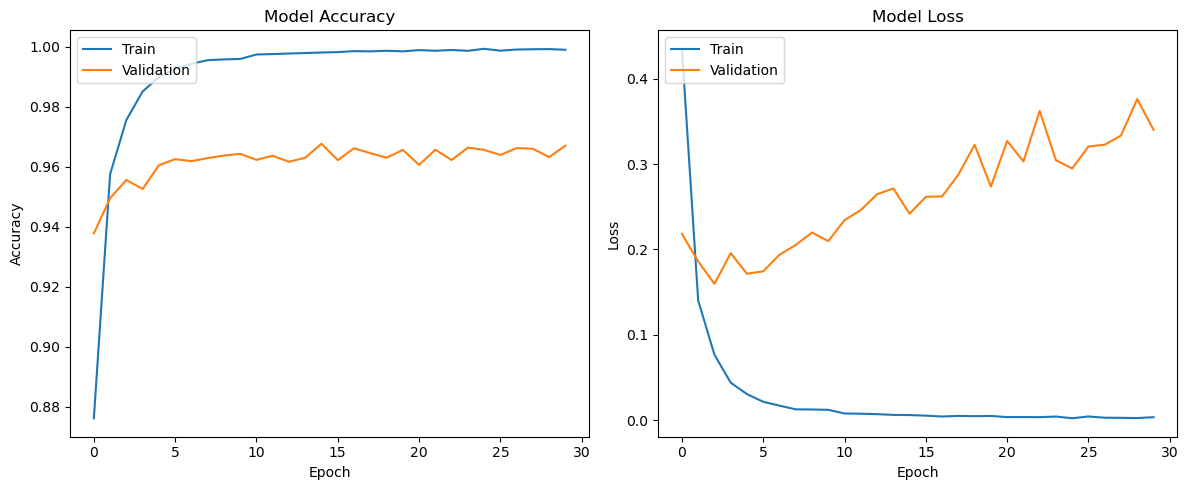

In [19]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Display the plot
plot_history(history)

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is already trained and has made predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


575/575 [==============================] - 15s 26ms/step


In [21]:
# Generate confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

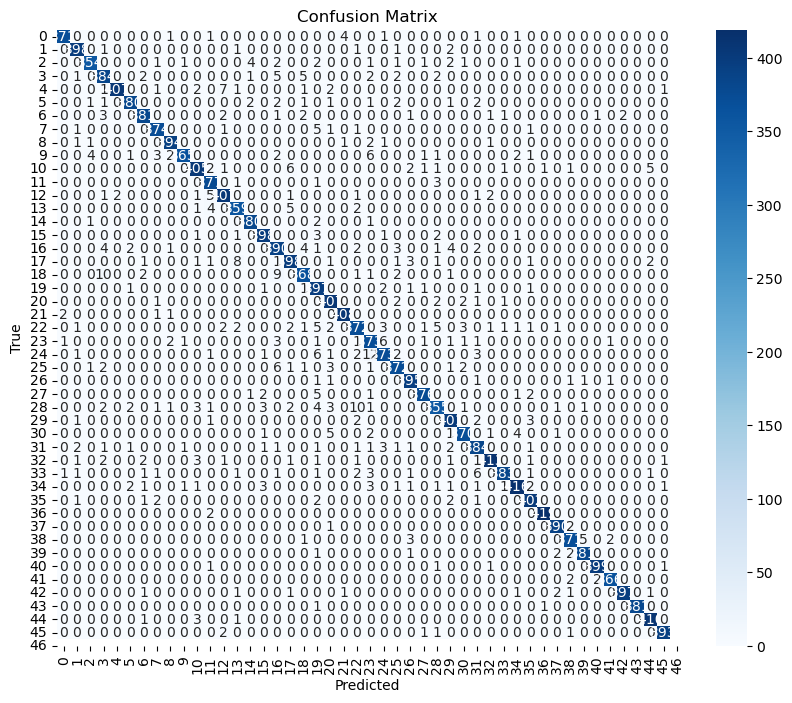

In [22]:
class_names= {0: 'क', 1: 'ख', 2: 'ग', 3: 'घ', 4: 'ङ', 5: 'च', 6: 'छ', 7: 'ज', 8: 'झ', 9: 'ञ', 10: 'ट', 11: 'ठ', 12: 'ड', 13: 'ढ', 14: 'ण', 15: 'त', 16: 'थ', 17: 'द', 18: 'ध', 19: 'न', 20: 'प', 21: 'फ', 22: 'ब', 23: 'भ', 24: 'म', 25: 'य', 26: 'र', 27: 'ल', 28: 'व', 29: 'श', 30: 'ष', 31: 'स', 32: 'ह', 33: 'क्ष', 34: 'त्र', 35: 'ज्ञ', 36: 'अ', 37: 'आ', 38: 'इ', 39: 'ई', 40: 'उ', 41: 'ऊ', 42: 'ऋ', 43: 'ए', 44: 'ऐ', 45: 'ओ', 46: 'औ'}

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [23]:
############################################     CHARACTER PREDICT     #####################################################
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# Path to the image file you want to predict
image_path = 'Downloads/Images/character_03_ga/11886.png'  # Replace with the actual path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(64, 64), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict probabilities for each class
predictions = model.predict(img_array)

# Get the predicted class for the sample
predicted_class = np.argmax(predictions)
confidence = predictions[0, predicted_class]

# Assuming you have a dictionary mapping class indices to character labels
class_labels = {0: 'क', 1: 'ख', 2: 'ग', 3: 'घ', 4: 'ङ', 5: 'च', 6: 'छ', 7: 'ज', 8: 'झ', 9: 'ञ', 10: 'ट', 11: 'ठ', 12: 'ड', 13: 'ढ', 14: 'ण', 15: 'त', 16: 'थ', 17: 'द', 18: 'ध', 19: 'न', 20: 'प', 21: 'फ', 22: 'ब', 23: 'भ', 24: 'म', 25: 'य', 26: 'र', 27: 'ल', 28: 'व', 29: 'श', 30: 'ष', 31: 'स', 32: 'ह', 33: 'क्ष', 34: 'त्र', 35: 'ज्ञ', 36: 'अ', 37: 'आ', 38: 'इ', 39: 'ई', 40: 'उ', 41: 'ऊ', 42: 'ऋ', 43: 'ए', 44: 'ऐ', 45: 'ओ', 46: 'औ'}

# Map predicted class index to character
predicted_character = class_labels[predicted_class]

# Display the predicted character and confidence
print(f'Predicted Character: {predicted_character}')
print(f'Confidence: {confidence*100}')


1/1 [==============================] - 0s 59ms/step
Predicted Character: म
Confidence: 95.70251703262329


In [1]:
#####################################  word  prediction ######################################

import cv2
import pytesseract
import os
from googletrans import Translator

# Path to the Tesseract executable (update it based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Set the tessdata directory
tessdata_dir = r'C:\Program Files\Tesseract-OCR\tessdata'
os.environ['TESSDATA_PREFIX'] = tessdata_dir

def predict_devanagari_word(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to preprocess the image
    _, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use Tesseract OCR to extract text from the image
    custom_config = r'--oem 3 --psm 6 outputbase digits -c tessedit_char_whitelist=ऀ-ॿ'
    
    try:
        detected_text = pytesseract.image_to_string(img, lang='hin+deva')
        return detected_text
    except Exception as e:
        print("Error during OCR:")
        print(e)
        return None

# Path to the image file you want to predict
image_path = r'Downloads\testrat.png'  # Replace with the actual path

# Predict the Devanagari word
predicted_word = predict_devanagari_word(image_path)

# Display the predicted word
if predicted_word:
    print(f'Predicted Devanagari Word: {predicted_word}')
else:
    print('Failed to predict Devanagari word.')

Predicted Devanagari Word: शक्ति अबिरामी



In [2]:
from googletrans import Translator

translator = Translator()

out = translator.translate(predicted_word, dest=input("Enter the language code to translate : "))

print("After translate=", out.text)

Enter the language code to translate : ja
After translate= シャクティアビラミ


In [82]:
########################################### LANGUAGE CODE ##################################################

afrikaans         'af'
albanian          'sq'
amharic           'am'
arabic            'ar'
armenian          'hy'
azerbaijani       'az'
basque            'eu'
belarusian        'be'
bengali           'bn'
bosnian           'bs'
bulgarian         'bg'
catalan           'ca'
cebuano           'ceb'
chichewa          'ny'
chinese (simplified)   'zh-CN'
chinese (traditional)  'zh-TW'
corsican          'co'
croatian          'hr'
czech             'cs'
danish            'da'
dutch             'nl'
english           'en'
esperanto         'eo'
estonian          'et'
filipino          'tl'
finnish           'fi'
french            'fr'
frisian           'fy'
galician          'gl'
georgian          'ka'
german            'de'
greek             'el'
gujarati          'gu'
haitian creole    'ht'
hausa             'ha'
hawaiian          'haw'
hebrew            'he'
hindi             'hi'
hmong             'hmn'
hungarian         'hu'
icelandic         'is'
igbo              'ig'
indonesian        'id'
irish             'ga'
italian           'it'
japanese          'ja'
javanese          'jw'
kannada           'kn'
kazakh            'kk'
khmer             'km'
kinyarwanda       'rw'
korean            'ko'
kurdish           'ku'
kyrgyz            'ky'
lao               'lo'
latin             'la'
latvian           'lv'
lithuanian        'lt'
luxembourgish     'lb'
macedonian        'mk'
malagasy          'mg'
malay            'ms'
malayalam        'ml'
maltese          'mt'
maori            'mi'
marathi          'mr'
mongolian        'mn'
myanmar (burmese)   'my'
nepali           'ne'
norwegian        'no'
odia             'or'
pashto           'ps'
persian          'fa'
polish           'pl'
portuguese       'pt'
punjabi          'pa'
romanian         'ro'
russian          'ru'
samoan           'sm'
scots gaelic     'gd'
serbian          'sr'
sesotho          'st'
shona            'sn'
sindhi           'sd'
sinhala          'si'
slovak           'sk'
slovenian        'sl'
somali           'so'
spanish          'es'
sundanese        'su'
swahili          'sw'
swedish          'sv'
tajik            'tg'
tamil            'ta'
telugu           'te'
thai             'th'
turkish          'tr'
ukrainian        'uk'
urdu             'ur'
uyghur           'ug'
uzbek            'uz'
vietnamese       'vi'
welsh            'cy'
xhosa            'xh'
yiddish          'yi'
yoruba           'yo'
zulu             'zu'#


NameError: name 'dest' is not defined

In [27]:
######################################### english word prediction  ####################################

import cv2
import pytesseract

# Path to the Tesseract executable (update it based on your installation)
pytesseract.pytesseract.tesseract_cmd=r"C:\\Program Files\Tesseract-OCR\tesseract.exe"
img = cv2.imread(r"C:\\Users\sundh\Downloads\unnamed.jpg")
detected_text = pytesseract.image_to_string(img)
print(detected_text)

BIBIC
LEARNING
ENGLISH

